## TF Estimators

In [1]:
import tensorflow as tf

from sklearn.datasets import make_classification, make_multilabel_classification
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import seaborn as sns

In [41]:
is_binary = True

if is_binary:
    x, y = make_classification(n_samples=1000, n_features=5, n_informative=2, class_sep=2, random_state=1)
else:
    classes = 3
    x, y = make_multilabel_classification(n_samples=3000, random_state=1, n_features=5, 
                                          n_classes=classes, sparse=False)
    y = np.sum(y * [2**i for i in range(classes)], axis=1)
y = y.reshape(-1,1)

In [42]:
fstring = f"| X Shape: {x.shape}\n| Y Shape: {y.shape}"
dashes = '+'+'-'*int(len(fstring)/2) + '+'
print(f"{dashes}\n{fstring}\n{dashes}")

+--------------------+
| X Shape: (1000, 5)
| Y Shape: (1000, 1)
+--------------------+


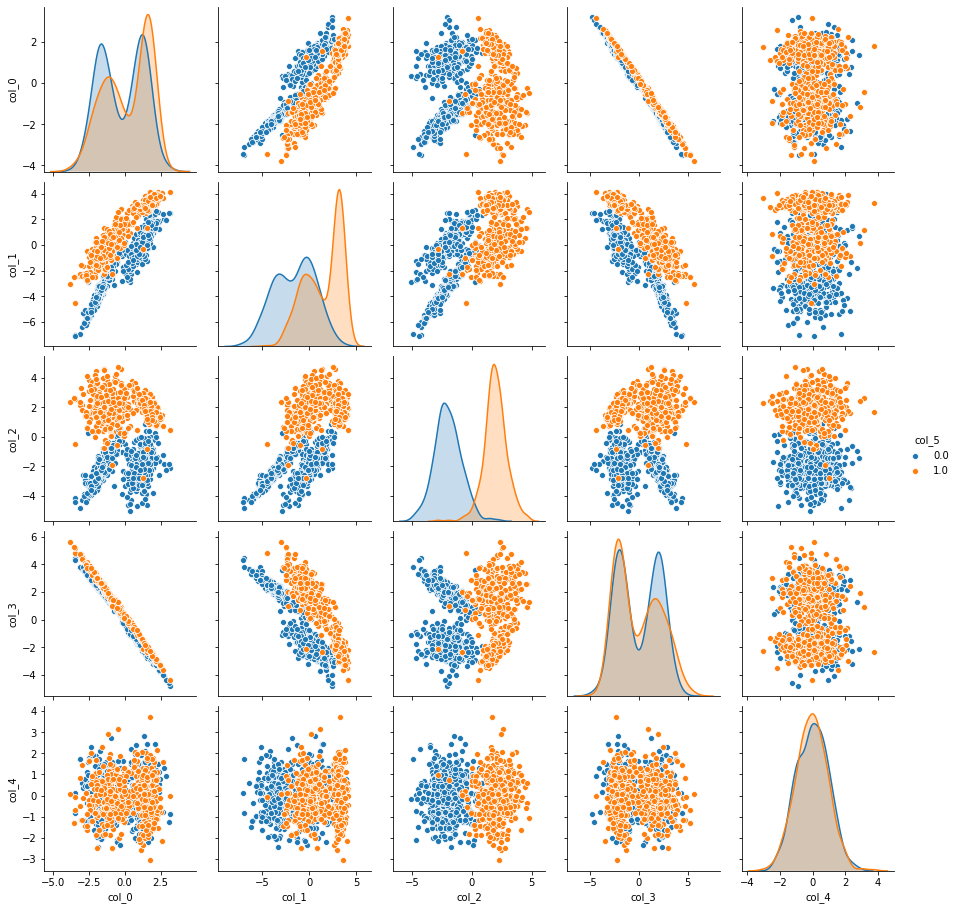

In [43]:
df_pd = pd.DataFrame(np.append(x,y, axis=1))
df_pd.columns = [f'col_{i}' for i in df_pd.columns]
sns.pairplot(df_pd, hue=df_pd.columns[-1])

In [44]:
feature_cols = [i for i in df_pd.columns[:-1]]

In [45]:
response_col = df_pd.columns[-1]

In [46]:
train_x, test_x, train_y, test_y = train_test_split(df_pd[feature_cols], df_pd[response_col].astype(int), test_size=0.2)

In [47]:
NUM_EXAMPLES = len(train_y)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn


In [48]:
train_input_fn = make_input_fn(train_x.merge(train_y, left_index=True, right_index=True), train_y)
eval_input_fn = make_input_fn(test_x.merge(test_y, left_index=True, right_index=True), test_y, shuffle=False, n_epochs=1)

In [49]:
tf_features = [tf.feature_column.numeric_column(i) for i in feature_cols]

#### Baseline

In [51]:
linear_est = tf.estimator.LinearClassifier(feature_columns=tf_features, n_classes=len(np.unique(df_pd[response_col]))+2)

# Train model.
linear_est.train(train_input_fn, max_steps=100)
linear_est.evaluate(eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/3m/69gn913d3b16j41lgp0hxb4mfhs5yn/T/tmpbueodvc0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a560d6810>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflo

{'accuracy': 0.985,
 'average_loss': 0.05060048,
 'loss': 10.120096,
 'global_step': 100}

#### Random Forest

In [52]:

params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to 
  # make an initial prediction before using any features (e.g. use the mean of 
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}
# tf.estimator.BoostedTreesClassifier?
est = tf.estimator.BoostedTreesClassifier(feature_columns=tf_features, 
                                          **params)
# Train model.
est.train(train_input_fn, max_steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/3m/69gn913d3b16j41lgp0hxb4mfhs5yn/T/tmpezbd3tfb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a559d4450>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflo

In [53]:
# Evaluation.
est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-02-09T20:05:39Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/3m/69gn913d3b16j41lgp0hxb4mfhs5yn/T/tmpezbd3tfb/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-02-09-20:05:40
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.995, accuracy_baseline = 0.53999996, auc = 0.9998994, auc_precision_recall = 0.99988246, average_loss = 0.029482646, global_step = 100, label/mean = 0.46, loss = 0.029482646, precision = 1.0, prediction/mean = 0.45659623, recall = 0.98913044
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:

{'accuracy': 0.995,
 'accuracy_baseline': 0.53999996,
 'auc': 0.9998994,
 'auc_precision_recall': 0.99988246,
 'average_loss': 0.029482646,
 'label/mean': 0.46,
 'loss': 0.029482646,
 'precision': 1.0,
 'prediction/mean': 0.45659623,
 'recall': 0.98913044,
 'global_step': 100}

#### DNN Classifier 

In [39]:
params = {'hidden_units': [30,20,10], 'feature_columns': tf_features, 'dropout':.1}

DNN_Classifier = tf.estimator.DNNClassifier(**params, n_classes=len(np.unique(df_pd[response_col]))+2)

DNN_Classifier.train(train_input_fn, max_steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/3m/69gn913d3b16j41lgp0hxb4mfhs5yn/T/tmpi1xx1vk0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a57f6fc50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflo

In [40]:
DNN_Classifier.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-02-09T17:42:22Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/3m/69gn913d3b16j41lgp0hxb4mfhs5yn/T/tmpi1xx1vk0/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-02-09-17:42:23
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.73833334, average_loss = 0.6844915, global_step = 100, loss = 410.69492
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /var/folders/3m/69gn913d3b16j41lgp0hxb4mfhs5yn/T/tmpi1xx1vk0/model.ckpt-100


{'accuracy': 0.73833334,
 'average_loss': 0.6844915,
 'loss': 410.69492,
 'global_step': 100}

In [ ]:
tf.